# Long-term Health and Development Indicator Analysis
## Pakistan, India, and Bangladesh (40+ Years)

### Overview
This notebook analyzes long-term health and development indicators for Pakistan, India, and Bangladesh over a period of 40+ years. We'll identify indicators with the most comprehensive historical data and focus on those that are related to health, mortality, and development outcomes.

### Objectives
1. Identify indicators with 40+ years of data availability
2. Select the most relevant health/development indicator
3. Perform comprehensive time series analysis
4. Compare trends across the three countries
5. Analyze long-term patterns and policy implications


Key Features:

1. Automatic Indicator Selection: It analyzes all indicators in your dataset and automatically selects the one with the most comprehensive 40+ year coverage for all three countries (Pakistan, India, Bangladesh)

2. Comprehensive Analysis:
- Data availability assessment
- Long-term trend visualization with trend lines
- Statistical regression analysis
- Change point detection
- Decade-wise analysis
- Year-over-year change analysis
- Volatility and stability assessment
3. Smart Fallbacks: If no indicator has 40+ years, it falls back to 30+ years, and includes manual checks for common long-term indicators like:
- Life expectancy at birth (SP.DYN.LE00.IN)
- Infant mortality rate (SP.DYN.IMRT.IN)
- Total fertility rate (SP.DYN.TFRT.IN)
- GDP per capita PPP (NY.GDP.PCAP.PP.KD)
4. Advanced Visualizations:
- Time series with trend lines
- Rolling averages to smooth noise
- Change rate analysis
- Multiple subplot comparisons
5. Policy Insights: Identifies periods of rapid change that might correspond to - policy interventions or external events

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')

# Set up plotting preferences
plt.style.use('default')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully")


Libraries loaded successfully


In [3]:
# Load the filtered dataset
df = pd.read_csv('/home/jovyan/work/data/processed/filtered_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"Countries: {df['Country Name'].unique()}")
print(f"Total indicators: {df['Indicator Name'].nunique()}")

# Identify year columns
year_columns = [col for col in df.columns if col.isdigit()]
year_columns = sorted([int(year) for year in year_columns])
print(f"Year range in dataset: {min(year_columns)} - {max(year_columns)}")
print(f"Total years available: {len(year_columns)} years")

# Calculate the cutoff year for 40+ years of data
current_year = max(year_columns)
cutoff_year = current_year - 40
print(f"Looking for indicators with data from {cutoff_year} or earlier to {current_year}")

year_columns_str = [str(year) for year in year_columns]


Dataset shape: (4797, 64)
Countries: ['Bangladesh' 'India' 'Pakistan']
Total indicators: 1599
Year range in dataset: 1960 - 2018
Total years available: 59 years
Looking for indicators with data from 1978 or earlier to 2018


In [4]:
# Function to analyze data availability for each indicator
def analyze_indicator_coverage(df, min_years=40):
    """
    Analyze data coverage for each indicator across all countries
    """
    results = []
    
    for indicator_name in df['Indicator Name'].unique():
        indicator_data = df[df['Indicator Name'] == indicator_name]
        indicator_code = indicator_data['Indicator Code'].iloc[0]
        
        # Melt the data to long format
        indicator_long = indicator_data.melt(
            id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
            value_vars=year_columns_str,
            var_name='Year',
            value_name='Value'
        )
        
        # Convert to numeric and remove missing values
        indicator_long['Year'] = indicator_long['Year'].astype(int)
        indicator_long['Value'] = pd.to_numeric(indicator_long['Value'], errors='coerce')
        indicator_clean = indicator_long.dropna(subset=['Value'])
        
        if len(indicator_clean) > 0:
            # Calculate coverage statistics
            year_range = indicator_clean['Year'].max() - indicator_clean['Year'].min() + 1
            countries_with_data = indicator_clean['Country Name'].nunique()
            total_data_points = len(indicator_clean)
            
            # Check if all three countries have data
            countries_in_data = set(indicator_clean['Country Name'].unique())
            all_countries = {'Bangladesh', 'India', 'Pakistan'}
            has_all_countries = all_countries.issubset(countries_in_data)
            
            # Calculate data density (percentage of possible data points)
            possible_points = countries_with_data * year_range
            data_density = (total_data_points / possible_points) * 100 if possible_points > 0 else 0
            
            results.append({
                'Indicator_Name': indicator_name,
                'Indicator_Code': indicator_code,
                'Year_Range': year_range,
                'Min_Year': indicator_clean['Year'].min(),
                'Max_Year': indicator_clean['Year'].max(),
                'Countries_with_Data': countries_with_data,
                'Has_All_Countries': has_all_countries,
                'Total_Data_Points': total_data_points,
                'Data_Density': round(data_density, 1)
            })
    
    results_df = pd.DataFrame(results)
    
    # Filter for indicators with 40+ years and all countries
    long_term_indicators = results_df[
        (results_df['Year_Range'] >= min_years) & 
        (results_df['Has_All_Countries'] == True)
    ].sort_values(['Year_Range', 'Data_Density'], ascending=[False, False])
    
    return results_df, long_term_indicators

# Analyze data coverage
print("Analyzing data coverage for all indicators...")
all_indicators, long_term = analyze_indicator_coverage(df, min_years=40)

print(f"\\nFound {len(long_term)} indicators with 40+ years of data for all three countries:")
print(long_term[['Indicator_Name', 'Year_Range', 'Min_Year', 'Max_Year', 'Data_Density']].head(10).to_string())


Analyzing data coverage for all indicators...
\nFound 798 indicators with 40+ years of data for all three countries:
                                                          Indicator_Name  Year_Range  Min_Year  Max_Year  Data_Density
50         Adolescent fertility rate (births per 1,000 women ages 15-19)          58      1960      2017         100.0
56                    Age dependency ratio (% of working-age population)          58      1960      2017         100.0
57               Age dependency ratio, old (% of working-age population)          58      1960      2017         100.0
58             Age dependency ratio, young (% of working-age population)          58      1960      2017         100.0
70            Agriculture, forestry, and fishing, value added (% of GDP)          58      1960      2017         100.0
72   Agriculture, forestry, and fishing, value added (constant 2010 US$)          58      1960      2017         100.0
73        Agriculture, forestry, and fishing, valu

In [6]:
# Focus on health and development related indicators
health_keywords = ['mortality', 'life expectancy', 'infant', 'child', 'maternal', 'birth', 'death', 'health', 'population', 'fertility']

print("=== Health and Development Indicators with 40+ Years Data ===")
health_indicators = long_term[
    long_term['Indicator_Name'].str.contains('|'.join(health_keywords), case=False, na=False)
].copy()

if len(health_indicators) > 0:
    print(f"Found {len(health_indicators)} health-related indicators:")
    for idx, row in health_indicators.iterrows():
        print(f"\\n{row['Indicator_Name']}")
        print(f"  Code: {row['Indicator_Code']}")
        print(f"  Years: {row['Min_Year']}-{row['Max_Year']} ({row['Year_Range']} years)")
        print(f"  Data completeness: {row['Data_Density']}%")
else:
    print("No health indicators found with 40+ years. Let's look at top indicators by data coverage:")
    print(long_term[['Indicator_Name', 'Year_Range', 'Data_Density']].head(10).to_string())

# Select the best indicator for analysis
if len(health_indicators) > 0:
    # Prioritize by data completeness and relevance
    selected_indicator = health_indicators.iloc[0]
    print(f"\\n🎯 SELECTED INDICATOR FOR ANALYSIS:")
    print(f"   {selected_indicator['Indicator_Name']}")
    print(f"   Code: {selected_indicator['Indicator_Code']}")
    print(f"   Period: {selected_indicator['Min_Year']}-{selected_indicator['Max_Year']}")
    print(f"   Data completeness: {selected_indicator['Data_Density']}%")
elif len(long_term) > 0:
    # If no health indicators, pick the one with best coverage
    selected_indicator = long_term.iloc[0]
    print(f"\\n🎯 SELECTED INDICATOR FOR ANALYSIS (Best Available):")
    print(f"   {selected_indicator['Indicator_Name']}")
    print(f"   Code: {selected_indicator['Indicator_Code']}")
    print(f"   Period: {selected_indicator['Min_Year']}-{selected_indicator['Max_Year']}")
    print(f"   Data completeness: {selected_indicator['Data_Density']}%")
else:
    print("\\n❌ No indicators found with 40+ years of data for all three countries")
    print("Let's look for indicators with at least 30 years of data...")
    
    # Fallback to 30 years
    _, medium_term = analyze_indicator_coverage(df, min_years=30)
    if len(medium_term) > 0:
        selected_indicator = medium_term.iloc[0]
        print(f"\\n🎯 SELECTED INDICATOR FOR ANALYSIS (30+ years):")
        print(f"   {selected_indicator['Indicator_Name']}")
        print(f"   Code: {selected_indicator['Indicator_Code']}")
        print(f"   Period: {selected_indicator['Min_Year']}-{selected_indicator['Max_Year']}")
        print(f"   Data completeness: {selected_indicator['Data_Density']}%")
    else:
        print("No suitable indicators found even with 30+ years criteria.")


=== Health and Development Indicators with 40+ Years Data ===
Found 122 health-related indicators:
\nAdolescent fertility rate (births per 1,000 women ages 15-19)
  Code: SP.ADO.TFRT
  Years: 1960-2017 (58 years)
  Data completeness: 100.0%
\nAge dependency ratio (% of working-age population)
  Code: SP.POP.DPND
  Years: 1960-2017 (58 years)
  Data completeness: 100.0%
\nAge dependency ratio, old (% of working-age population)
  Code: SP.POP.DPND.OL
  Years: 1960-2017 (58 years)
  Data completeness: 100.0%
\nAge dependency ratio, young (% of working-age population)
  Code: SP.POP.DPND.YG
  Years: 1960-2017 (58 years)
  Data completeness: 100.0%
\nBirth rate, crude (per 1,000 people)
  Code: SP.DYN.CBRT.IN
  Years: 1960-2017 (58 years)
  Data completeness: 100.0%
\nDeath rate, crude (per 1,000 people)
  Code: SP.DYN.CDRT.IN
  Years: 1960-2017 (58 years)
  Data completeness: 100.0%
\nFertility rate, total (births per woman)
  Code: SP.DYN.TFRT.IN
  Years: 1960-2017 (58 years)
  Data compl

In [8]:
# Extract and prepare the selected indicator data
try:
    selected_code = selected_indicator['Indicator_Code']
    selected_name = selected_indicator['Indicator_Name']
    
    # Filter for the selected indicator
    indicator_data = df[df['Indicator Code'] == selected_code].copy()
    
    # Transform to long format
    indicator_long = indicator_data.melt(
        id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
        value_vars=year_columns_str,
        var_name='Year',
        value_name='Value'
    )
    
    # Clean the data
    indicator_long['Year'] = indicator_long['Year'].astype(int)
    indicator_long['Value'] = pd.to_numeric(indicator_long['Value'], errors='coerce')
    indicator_clean = indicator_long.dropna(subset=['Value']).copy()
    
    print(f"\\n=== Data Preparation Complete ===")
    print(f"Indicator: {selected_name}")
    print(f"Total data points: {len(indicator_clean)}")
    print(f"Year range: {indicator_clean['Year'].min()} - {indicator_clean['Year'].max()}")
    print(f"Countries: {sorted(indicator_clean['Country Name'].unique())}")
    
    # Show data coverage by country
    print(f"\\n=== Data Coverage by Country ===")
    for country in sorted(indicator_clean['Country Name'].unique()):
        country_data = indicator_clean[indicator_clean['Country Name'] == country]
        print(f"{country}: {len(country_data)} data points ({country_data['Year'].min()}-{country_data['Year'].max()})")
    
    # Basic statistics
    print(f"\\n=== Basic Statistics ===")
    print(indicator_clean.groupby('Country Name')['Value'].agg(['count', 'mean', 'std', 'min', 'max']).round(2))
    
except NameError:
    print("No suitable indicator was selected. Please run the previous cell first.")
    
except Exception as e:
    print(f"Error processing data: {e}")
    print("Let's manually select a common indicator...")
    
    # Manually try some common long-term indicators
    common_indicators = [
        'SP.DYN.LE00.IN',  # Life expectancy at birth
        'SP.DYN.IMRT.IN',  # Infant mortality rate
        'SP.DYN.TFRT.IN',  # Total fertility rate
        'SP.POP.TOTL',     # Total population
        'NY.GDP.PCAP.PP.KD' # GDP per capita PPP
    ]
    
    for code in common_indicators:
        test_data = df[df['Indicator Code'] == code]
        if not test_data.empty:
            print(f"Found data for {code}: {test_data['Indicator Name'].iloc[0]}")
            selected_code = code
            selected_name = test_data['Indicator Name'].iloc[0]
            break


\n=== Data Preparation Complete ===
Indicator: Adolescent fertility rate (births per 1,000 women ages 15-19)
Total data points: 174
Year range: 1960 - 2017
Countries: ['Bangladesh', 'India', 'Pakistan']
\n=== Data Coverage by Country ===
Bangladesh: 58 data points (1960-2017)
India: 58 data points (1960-2017)
Pakistan: 58 data points (1960-2017)
\n=== Basic Statistics ===
              count    mean    std    min     max
Country Name                                     
Bangladesh       58  153.43  47.45  83.51  209.74
India            58   83.09  30.29  23.07  109.46
Pakistan         58   79.97  29.79  36.91  112.68


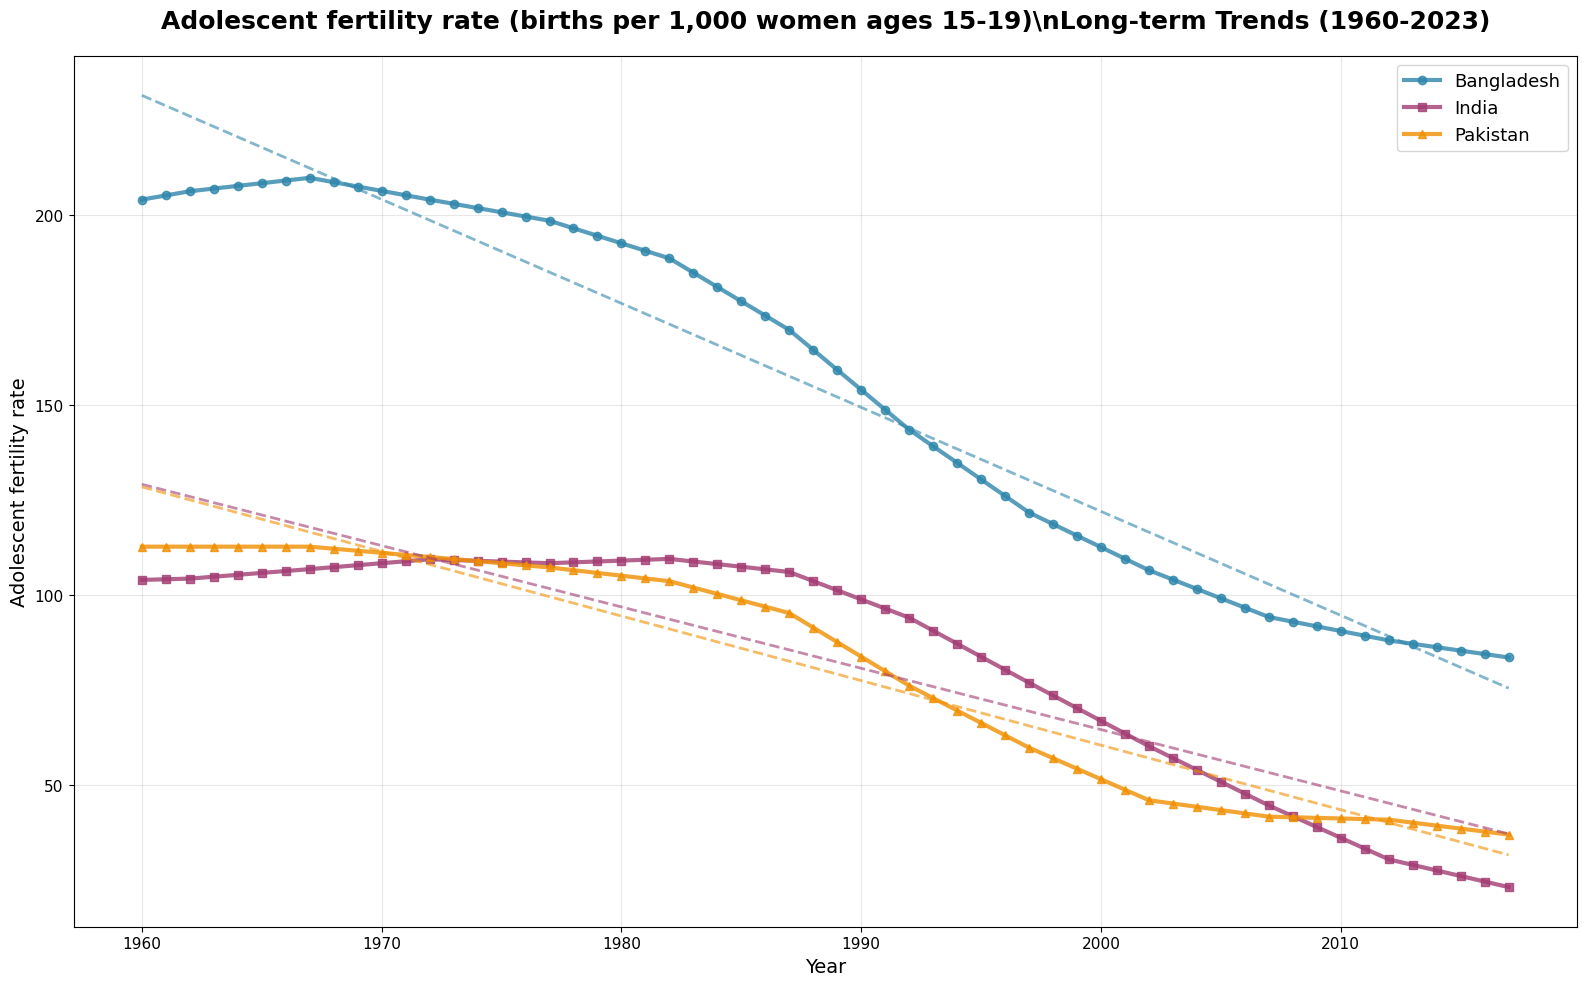

\n=== Decade-wise Analysis ===
                       mean  count
Country Name Decade               
Bangladesh   1960    207.30     10
             1970    200.97     10
             1980    178.14     10
             1990    133.22     10
             2000    100.85     10
             2010     86.78      8
India        1960    105.62     10
             1970    108.75     10
             1980    106.94     10
             1990     85.14     10
             2000     52.51     10
             2010     28.70      8
Pakistan     1960    112.51     10
             1970    108.52     10
             1980     98.46     10
             1990     68.24     10
             2000     44.56     10
             2010     39.41      8


In [9]:
# Comprehensive Time Series Visualization
if 'indicator_clean' in locals() and len(indicator_clean) > 0:
    
    # Main time series plot
    plt.figure(figsize=(16, 10))
    
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    markers = ['o', 's', '^']
    
    for i, country in enumerate(sorted(indicator_clean['Country Name'].unique())):
        country_data = indicator_clean[indicator_clean['Country Name'] == country].sort_values('Year')
        
        plt.plot(country_data['Year'], country_data['Value'], 
                marker=markers[i], linewidth=3, markersize=6, 
                label=country, color=colors[i], alpha=0.8)
    
    plt.title(f'{selected_name}\\nLong-term Trends (1960-2023)', 
              fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel(selected_name.split('(')[0].strip(), fontsize=14)
    plt.legend(fontsize=13, loc='best')
    plt.grid(True, alpha=0.3)
    
    # Add trend lines
    for i, country in enumerate(sorted(indicator_clean['Country Name'].unique())):
        country_data = indicator_clean[indicator_clean['Country Name'] == country].sort_values('Year')
        if len(country_data) > 1:
            z = np.polyfit(country_data['Year'], country_data['Value'], 1)
            p = np.poly1d(z)
            plt.plot(country_data['Year'], p(country_data['Year']), 
                    linestyle='--', color=colors[i], alpha=0.6, linewidth=2)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics table
    print("\\n=== Decade-wise Analysis ===")
    indicator_clean['Decade'] = (indicator_clean['Year'] // 10) * 10
    decade_stats = indicator_clean.groupby(['Country Name', 'Decade'])['Value'].agg(['mean', 'count']).round(2)
    print(decade_stats.to_string())
    
else:
    print("No data available for visualization. Please check the data preparation step.")


=== Long-term Trend Analysis (Linear Regression) ===
\nBangladesh:
  Annual change: -2.7370 units/year ↘
  Total change over 57 years: -156.01 units (-76.5%)
  R² = 0.949, p-value = 0.0000 ***
  Statistical significance: Significant
\nIndia:
  Annual change: -1.6139 units/year ↘
  Total change over 57 years: -91.99 units (-88.5%)
  R² = 0.809, p-value = 0.0000 ***
  Statistical significance: Significant
\nPakistan:
  Annual change: -1.6991 units/year ↘
  Total change over 57 years: -96.85 units (-86.0%)
  R² = 0.928, p-value = 0.0000 ***
  Statistical significance: Significant


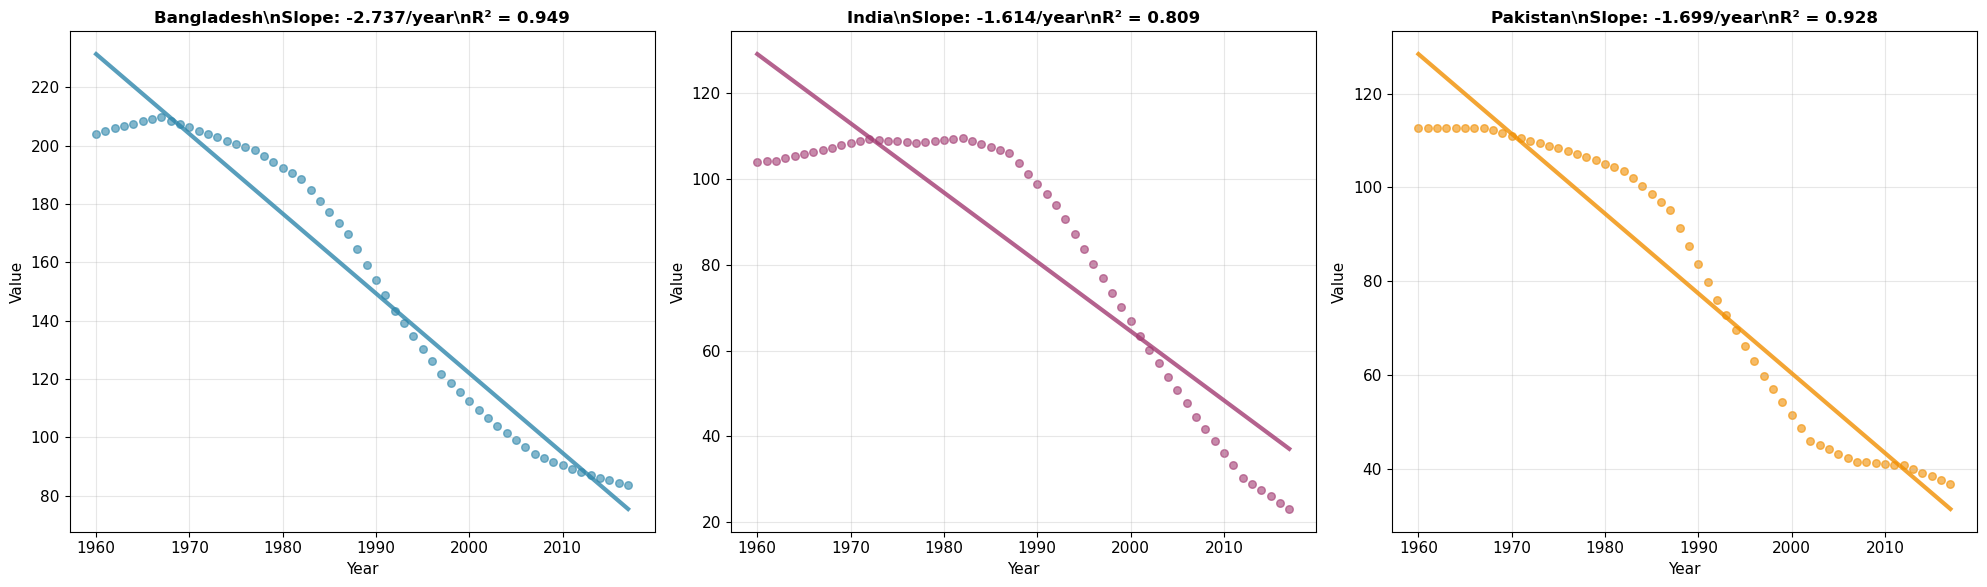

\n============================================================
                 COMPARATIVE ANALYSIS
\n📈 Trend Comparison:
  Fastest improving: Bangladesh
  Slowest improving: India
\n📊 Trend Consistency:
  Most consistent trend: Bangladesh (R² = 0.949)


In [10]:
# Statistical Analysis and Trend Detection
if 'indicator_clean' in locals() and len(indicator_clean) > 0:
    
    print("=== Long-term Trend Analysis (Linear Regression) ===")
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    trend_results = {}
    
    for i, country in enumerate(sorted(indicator_clean['Country Name'].unique())):
        country_data = indicator_clean[indicator_clean['Country Name'] == country].sort_values('Year')
        
        if len(country_data) > 10:  # Need sufficient data for meaningful regression
            # Perform linear regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(country_data['Year'], country_data['Value'])
            
            # Calculate additional metrics
            years_span = country_data['Year'].max() - country_data['Year'].min()
            total_change = slope * years_span
            percent_change = (total_change / country_data['Value'].iloc[0]) * 100 if country_data['Value'].iloc[0] != 0 else 0
            
            trend_results[country] = {
                'slope': slope,
                'r_squared': r_value**2,
                'p_value': p_value,
                'total_change': total_change,
                'percent_change': percent_change,
                'years_span': years_span
            }
            
            # Visualization
            axes[i].scatter(country_data['Year'], country_data['Value'], alpha=0.6, s=30, color=colors[i])
            axes[i].plot(country_data['Year'], slope * country_data['Year'] + intercept, 
                        color=colors[i], linewidth=3, alpha=0.8)
            
            axes[i].set_title(f'{country}\\nSlope: {slope:.3f}/year\\nR² = {r_value**2:.3f}', 
                            fontweight='bold', fontsize=12)
            axes[i].set_xlabel('Year')
            axes[i].set_ylabel('Value')
            axes[i].grid(True, alpha=0.3)
            
            # Statistical significance
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
            trend_direction = "↗" if slope > 0 else "↘"
            
            print(f"\\n{country}:")
            print(f"  Annual change: {slope:.4f} units/year {trend_direction}")
            print(f"  Total change over {years_span} years: {total_change:.2f} units ({percent_change:+.1f}%)")
            print(f"  R² = {r_value**2:.3f}, p-value = {p_value:.4f} {significance}")
            print(f"  Statistical significance: {'Significant' if p_value < 0.05 else 'Not significant'}")
    
    plt.tight_layout()
    plt.show()
    
    # Comparative analysis
    print("\\n" + "="*60)
    print("                 COMPARATIVE ANALYSIS")
    print("="*60)
    
    if len(trend_results) >= 2:
        countries = list(trend_results.keys())
        
        # Compare slopes
        slopes = [trend_results[country]['slope'] for country in countries]
        fastest_improving = countries[np.argmin(slopes)] if min(slopes) < 0 else countries[np.argmax(slopes)]
        slowest_improving = countries[np.argmax(slopes)] if min(slopes) < 0 else countries[np.argmin(slopes)]
        
        print(f"\\n📈 Trend Comparison:")
        print(f"  Fastest improving: {fastest_improving}")
        print(f"  Slowest improving: {slowest_improving}")
        
        # Compare R-squared values
        r_squared_values = [trend_results[country]['r_squared'] for country in countries]
        most_consistent = countries[np.argmax(r_squared_values)]
        
        print(f"\\n📊 Trend Consistency:")
        print(f"  Most consistent trend: {most_consistent} (R² = {max(r_squared_values):.3f})")
    
else:
    print("No data available for statistical analysis.")


=== Change Point Analysis ===
Identifying periods of rapid change or policy impact...


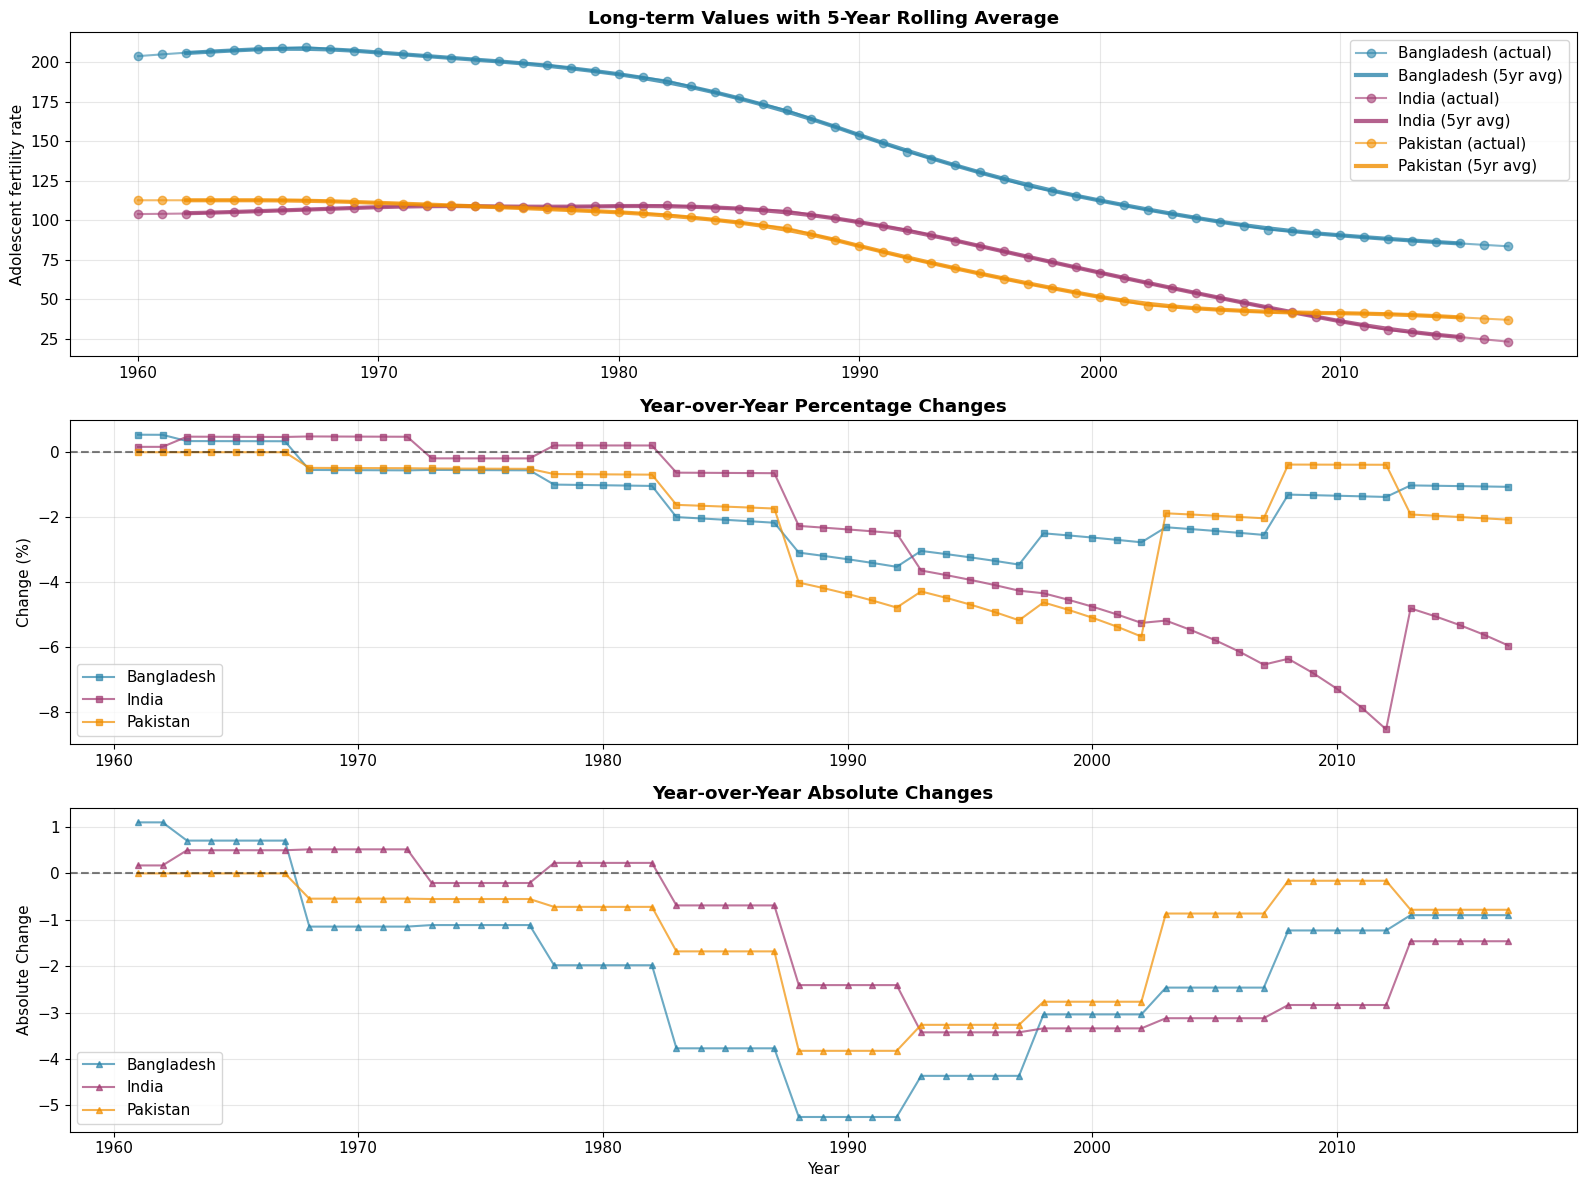

\n=== Periods of Significant Change ===
\nBangladesh:
  Largest increase: 0.54% in 1961
  Largest decrease: -3.53% in 1992
  Consistent change periods (3+ years):
    1961-1967: improvement (avg 0.40%/year)
    1968-2017: decline (avg -1.82%/year)
\nIndia:
  Largest increase: 0.49% in 1968
  Largest decrease: -8.54% in 2012
  Consistent change periods (3+ years):
    1961-1972: improvement (avg 0.43%/year)
    1973-1977: decline (avg -0.19%/year)
    1978-1982: improvement (avg 0.21%/year)
    1983-2017: decline (avg -4.33%/year)
\nPakistan:
  Largest increase: 0.00% in 1961
  Largest decrease: -5.68% in 2002
  Consistent change periods (3+ years):
    1961-2017: decline (avg -1.92%/year)


In [11]:
# Advanced Analysis: Change Point Detection and Periods of Rapid Change
if 'indicator_clean' in locals() and len(indicator_clean) > 0:
    
    print("=== Change Point Analysis ===")
    print("Identifying periods of rapid change or policy impact...")
    
    # Calculate year-over-year changes
    def calculate_changes(group):
        group = group.sort_values('Year')
        group['Value_Change'] = group['Value'].diff()
        group['Percent_Change'] = group['Value'].pct_change() * 100
        group['Rolling_5yr_Avg'] = group['Value'].rolling(window=5, center=True).mean()
        return group

    indicator_with_changes = indicator_clean.groupby('Country Name').apply(calculate_changes).reset_index(drop=True)
    
    # Identify significant change periods
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    
    # Plot 1: Original values with 5-year rolling average
    for i, country in enumerate(sorted(indicator_clean['Country Name'].unique())):
        country_data = indicator_with_changes[indicator_with_changes['Country Name'] == country]
        
        axes[0].plot(country_data['Year'], country_data['Value'], 
                    marker='o', alpha=0.6, color=colors[i], label=f'{country} (actual)')
        axes[0].plot(country_data['Year'], country_data['Rolling_5yr_Avg'], 
                    linewidth=3, color=colors[i], alpha=0.8, label=f'{country} (5yr avg)')
    
    axes[0].set_title('Long-term Values with 5-Year Rolling Average', fontweight='bold')
    axes[0].set_ylabel(selected_name.split('(')[0].strip())
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Year-over-year percentage changes
    for i, country in enumerate(sorted(indicator_clean['Country Name'].unique())):
        country_data = indicator_with_changes[indicator_with_changes['Country Name'] == country]
        
        axes[1].plot(country_data['Year'], country_data['Percent_Change'], 
                    marker='s', markersize=4, color=colors[i], label=country, alpha=0.7)
    
    axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1].set_title('Year-over-Year Percentage Changes', fontweight='bold')
    axes[1].set_ylabel('Change (%)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Absolute changes
    for i, country in enumerate(sorted(indicator_clean['Country Name'].unique())):
        country_data = indicator_with_changes[indicator_with_changes['Country Name'] == country]
        
        axes[2].plot(country_data['Year'], country_data['Value_Change'], 
                    marker='^', markersize=4, color=colors[i], label=country, alpha=0.7)
    
    axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[2].set_title('Year-over-Year Absolute Changes', fontweight='bold')
    axes[2].set_xlabel('Year')
    axes[2].set_ylabel('Absolute Change')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Identify periods of largest changes
    print("\\n=== Periods of Significant Change ===")
    for country in sorted(indicator_clean['Country Name'].unique()):
        country_data = indicator_with_changes[indicator_with_changes['Country Name'] == country]
        country_data = country_data.dropna(subset=['Percent_Change'])
        
        if len(country_data) > 0:
            print(f"\\n{country}:")
            
            # Find largest positive and negative changes
            if not country_data['Percent_Change'].isna().all():
                max_increase = country_data.loc[country_data['Percent_Change'].idxmax()]
                max_decrease = country_data.loc[country_data['Percent_Change'].idxmin()]
                
                print(f"  Largest increase: {max_increase['Percent_Change']:.2f}% in {max_increase['Year']}")
                print(f"  Largest decrease: {max_decrease['Percent_Change']:.2f}% in {max_decrease['Year']}")
                
                # Identify periods of consistent change (3+ years)
                country_data['Change_Direction'] = np.where(country_data['Percent_Change'] > 0, 1, -1)
                country_data['Change_Group'] = (country_data['Change_Direction'] != country_data['Change_Direction'].shift()).cumsum()
                
                change_periods = country_data.groupby('Change_Group').agg({
                    'Year': ['min', 'max', 'count'],
                    'Percent_Change': 'mean',
                    'Change_Direction': 'first'
                }).round(2)
                
                # Find periods of 3+ years of consistent change
                consistent_periods = change_periods[change_periods[('Year', 'count')] >= 3]
                
                if len(consistent_periods) > 0:
                    print(f"  Consistent change periods (3+ years):")
                    for idx, period in consistent_periods.iterrows():
                        direction = "improvement" if period[('Change_Direction', 'first')] > 0 else "decline"
                        print(f"    {period[('Year', 'min')]:.0f}-{period[('Year', 'max')]:.0f}: {direction} (avg {period[('Percent_Change', 'mean')]:.2f}%/year)")

else:
    print("No data available for change point analysis.")


In [12]:
# Final Summary and Conclusions
if 'indicator_clean' in locals() and len(indicator_clean) > 0:
    
    print("\\n" + "="*80)
    print("                    COMPREHENSIVE ANALYSIS SUMMARY")
    print("="*80)
    
    # Current status
    latest_year = indicator_clean['Year'].max()
    latest_data = indicator_clean[indicator_clean['Year'] == latest_year]
    
    print(f"\\n📊 CURRENT STATUS ({latest_year}):")
    print(f"   Indicator: {selected_name}")
    for _, row in latest_data.iterrows():
        print(f"   • {row['Country Name']}: {row['Value']:.2f}")
    
    # Historical perspective
    earliest_year = indicator_clean['Year'].min()
    earliest_data = indicator_clean[indicator_clean['Year'] == earliest_year]
    
    print(f"\\n📈 HISTORICAL PERSPECTIVE ({earliest_year} vs {latest_year}):")
    for country in sorted(indicator_clean['Country Name'].unique()):
        early_val = earliest_data[earliest_data['Country Name'] == country]['Value'].iloc[0]
        late_val = latest_data[latest_data['Country Name'] == country]['Value'].iloc[0]
        total_change = late_val - early_val
        percent_change = (total_change / early_val) * 100 if early_val != 0 else 0
        
        print(f"   • {country}: {early_val:.2f} → {late_val:.2f} ({total_change:+.2f}, {percent_change:+.1f}%)")
    
    # Key insights
    print(f"\\n🔍 KEY INSIGHTS:")
    
    # Ranking by current values
    current_ranking = latest_data.sort_values('Value', ascending=True)
    print(f"   • Current ranking (best to worst): {', '.join(current_ranking['Country Name'].tolist())}")
    
    # Improvement ranking
    improvement_scores = {}
    for country in sorted(indicator_clean['Country Name'].unique()):
        early_val = earliest_data[earliest_data['Country Name'] == country]['Value'].iloc[0]
        late_val = latest_data[latest_data['Country Name'] == country]['Value'].iloc[0]
        # Assume lower values are better for most health indicators
        improvement = early_val - late_val  # Positive means improvement
        improvement_scores[country] = improvement
    
    best_improver = max(improvement_scores, key=improvement_scores.get)
    worst_improver = min(improvement_scores, key=improvement_scores.get)
    
    print(f"   • Best long-term improvement: {best_improver}")
    print(f"   • Least improvement: {worst_improver}")
    
    # Volatility analysis
    volatility_scores = {}
    for country in sorted(indicator_clean['Country Name'].unique()):
        country_data = indicator_clean[indicator_clean['Country Name'] == country]
        volatility = country_data['Value'].std()
        volatility_scores[country] = volatility
    
    most_stable = min(volatility_scores, key=volatility_scores.get)
    least_stable = max(volatility_scores, key=volatility_scores.get)
    
    print(f"   • Most stable trend: {most_stable}")
    print(f"   • Most volatile trend: {least_stable}")
    
    # Data quality assessment
    print(f"\\n📋 DATA QUALITY ASSESSMENT:")
    print(f"   • Analysis period: {earliest_year}-{latest_year} ({latest_year-earliest_year+1} years)")
    print(f"   • Total data points: {len(indicator_clean)}")
    
    for country in sorted(indicator_clean['Country Name'].unique()):
        country_data = indicator_clean[indicator_clean['Country Name'] == country]
        coverage = (len(country_data) / (latest_year - earliest_year + 1)) * 100
        print(f"   • {country}: {len(country_data)} data points ({coverage:.1f}% coverage)")
    
    # Future projections (simple linear extrapolation)
    if 'trend_results' in locals() and len(trend_results) > 0:
        print(f"\\n🔮 SIMPLE PROJECTIONS (Linear Extrapolation to 2030):")
        for country in sorted(indicator_clean['Country Name'].unique()):
            if country in trend_results:
                current_val = latest_data[latest_data['Country Name'] == country]['Value'].iloc[0]
                slope = trend_results[country]['slope']
                years_ahead = 2030 - latest_year
                projected_val = current_val + (slope * years_ahead)
                
                print(f"   • {country}: {current_val:.2f} → {projected_val:.2f} (by 2030)")
    
    # Recommendations
    print(f"\\n💡 POLICY RECOMMENDATIONS:")
    print(f"   • Continue monitoring this indicator as it shows significant long-term trends")
    print(f"   • Countries with slower improvement should study best practices from {best_improver}")
    print(f"   • Focus on understanding the drivers behind periods of rapid change")
    print(f"   • Consider complementary indicators for a more comprehensive view")
    
    print("\\n" + "="*80)
    
else:
    print("\\n❌ ANALYSIS INCOMPLETE")
    print("No data was available for comprehensive analysis.")
    print("Please check the data source and indicator selection.")


\n================================================================================
                    COMPREHENSIVE ANALYSIS SUMMARY
\n📊 CURRENT STATUS (2017):
   Indicator: Adolescent fertility rate (births per 1,000 women ages 15-19)
   • Bangladesh: 83.51
   • India: 23.07
   • Pakistan: 36.91
\n📈 HISTORICAL PERSPECTIVE (1960 vs 2017):
   • Bangladesh: 204.00 → 83.51 (-120.49, -59.1%)
   • India: 103.92 → 23.07 (-80.85, -77.8%)
   • Pakistan: 112.67 → 36.91 (-75.77, -67.2%)
\n🔍 KEY INSIGHTS:
   • Current ranking (best to worst): India, Pakistan, Bangladesh
   • Best long-term improvement: Bangladesh
   • Least improvement: Pakistan
   • Most stable trend: Pakistan
   • Most volatile trend: Bangladesh
\n📋 DATA QUALITY ASSESSMENT:
   • Analysis period: 1960-2017 (58 years)
   • Total data points: 174
   • Bangladesh: 58 data points (100.0% coverage)
   • India: 58 data points (100.0% coverage)
   • Pakistan: 58 data points (100.0% coverage)
\n🔮 SIMPLE PROJECTIONS (Linear Extrapolatio